In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess

In [170]:
nyc_sales = pd.read_csv('nyc-property-sales.csv')
nyc_sales.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,apartment_number,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date
0,5.0,ANNADALE,01 ONE FAMILY HOMES,1,5391.0,7.0,A5,,10312.0,1.0,0.0,1.0,3655.0,1110.0,2002.0,1.0,A5,365040.0,2003-03-05
1,5.0,ANNADALE,01 ONE FAMILY HOMES,1,5391.0,8.0,A5,,10312.0,1.0,0.0,1.0,3149.0,1110.0,2002.0,1.0,A5,353886.0,2003-01-13
2,5.0,ANNADALE,01 ONE FAMILY HOMES,1,5391.0,12.0,A5,,10312.0,1.0,0.0,1.0,1746.0,1110.0,2002.0,1.0,A5,310000.0,2003-07-25
3,5.0,ANNADALE,01 ONE FAMILY HOMES,1,5391.0,13.0,A5,,10312.0,1.0,0.0,1.0,1871.0,1110.0,2002.0,1.0,A5,299130.0,2003-09-05
4,5.0,ANNADALE,01 ONE FAMILY HOMES,1,5391.0,15.0,A5,,10312.0,1.0,0.0,1.0,4678.0,1110.0,2002.0,1.0,A5,304099.0,2003-09-19


In [171]:
# Seperate Housing Type Data
ab = nyc_sales[nyc_sales['building_class_at_time_of_sale'].str.contains(r'^[AB]\d+', na=False)]
ab = ab[['sale_price', 'sale_date']]
ab = ab[ab['sale_price']>0]

cd = nyc_sales[nyc_sales['building_class_at_time_of_sale'].str.contains(r'^[CD]\d+', na=False)]
cd = cd[['sale_price', 'sale_date']]
cd = cd[cd['sale_price']>0]

In [172]:
df = nyc_sales[['sale_price', 'sale_date']]
df = df[df['sale_price']>0]
df.shape

(1352471, 2)

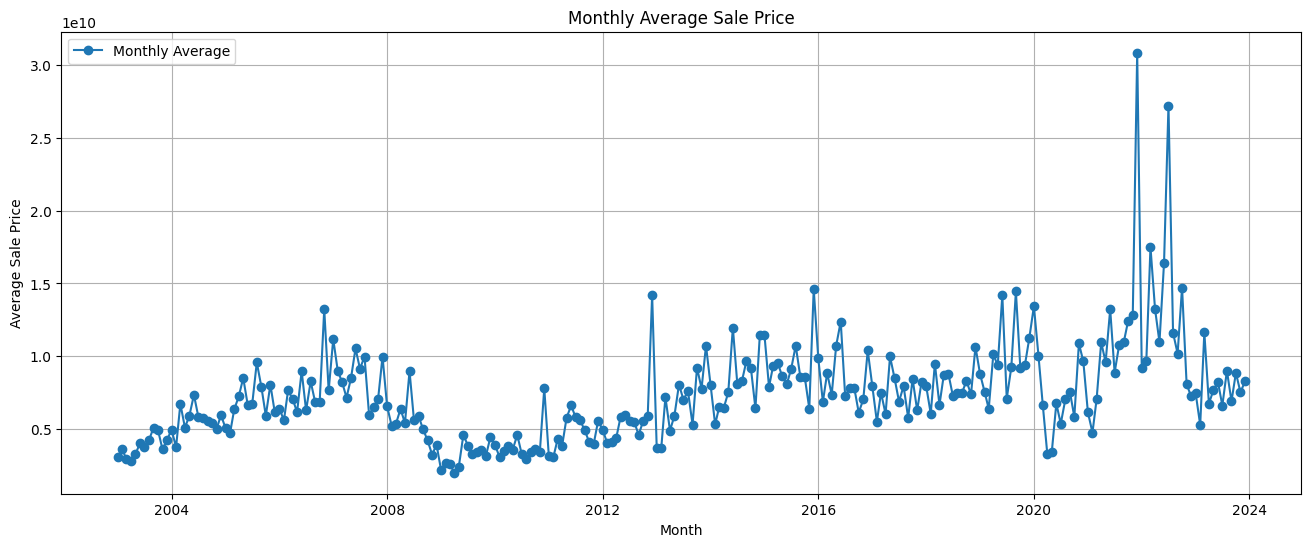

In [173]:
# aggregate monthly sum data

df['sale_date'] = pd.to_datetime(df['sale_date'])
df['month'] = df['sale_date'].dt.to_period('M')
df['week'] = df['sale_date'].dt.to_period('W')

monthly_avg = df.groupby('month')['sale_price'].sum().reset_index()  # avg here is a proxy name for sum
monthly_avg['month'] = monthly_avg['month'].dt.to_timestamp()
plt.figure(figsize=(16, 6))
plt.plot(monthly_avg['month'], monthly_avg['sale_price'], marker='o', label='Monthly Average')
plt.title('Monthly Average Sale Price')
plt.xlabel('Month')
plt.ylabel('Average Sale Price')
plt.grid()
plt.legend()
plt.show()

# EDA

In [174]:
data = monthly_avg
data.head()

,month,sale_price
0,2003-01-01,3.116479e+09
1,2003-02-01,3.655906e+09
2,2003-03-01,2.921552e+09
3,2003-04-01,2.813786e+09
4,2003-05-01,3.273580e+09


In [175]:
from prophet import Prophet
import matplotlib.dates as mdates

In [176]:
data['month'] = pd.to_datetime(data['month'])
df = data.rename(columns={'month': 'ds', 'sale_price': 'y'})

In [177]:
df

,ds,y
0,2003-01-01,3.116479e+09
1,2003-02-01,3.655906e+09
2,2003-03-01,2.921552e+09
3,2003-04-01,2.813786e+09
4,2003-05-01,3.273580e+09
...,...,...
247,2023-08-01,9.005704e+09
248,2023-09-01,6.916530e+09
249,2023-10-01,8.863907e+09
250,2023-11-01,7.516769e+09


### Stationary

In [45]:
from statsmodels.tsa.stattools import adfuller

adfuller(df['y'])

(np.float64(-2.542383277624035),
 np.float64(0.10549953858406408),
 14,
 237,
 {'1%': np.float64(-3.4582467982399105),
  '5%': np.float64(-2.8738137461081323),
  '10%': np.float64(-2.5733111490323846)},
 np.float64(10866.243490391906))

In [121]:
# non-stationary, need to take 1st difference for further EDA
df['y_diff'] = df['y'].diff()

## Check Seasonality

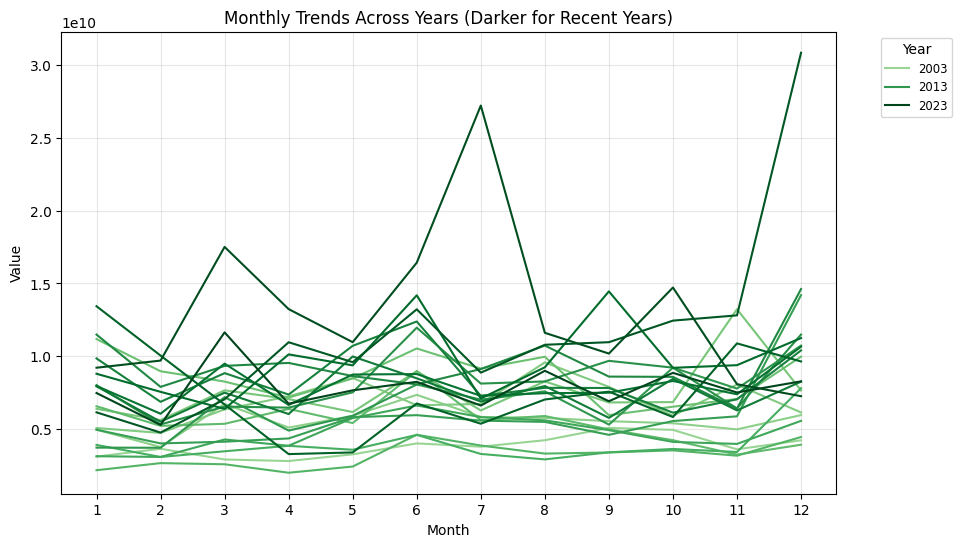

In [38]:
from matplotlib import cm

df['ds'] = pd.to_datetime(df['ds'])

# Extract year and month
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month

monthly_trends = df.pivot(index='year', columns='month', values='y')
years = monthly_trends.index
num_years = len(years)
colors = cm.Greens(np.linspace(0.4, 1, num_years))  # Greens colormap

# Plot the trends
plt.figure(figsize=(10, 6))
for i, year in enumerate(years):
    plt.plot(
        monthly_trends.columns, 
        monthly_trends.loc[year], 
        color=colors[i], 
        label=str(year) if i % 10 == 0 else ""  # Add a label every 10 years
    )

# Add legend and labels
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Monthly Trends Across Years (Darker for Recent Years)')
plt.xticks(range(1, 13))
plt.grid(alpha=0.3)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()


### Statistical Tests for Seasonality

Ljung-Box Test Results:
      lb_stat      lb_pvalue
12  592.07565  5.215947e-119


<Figure size 1000x600 with 0 Axes>

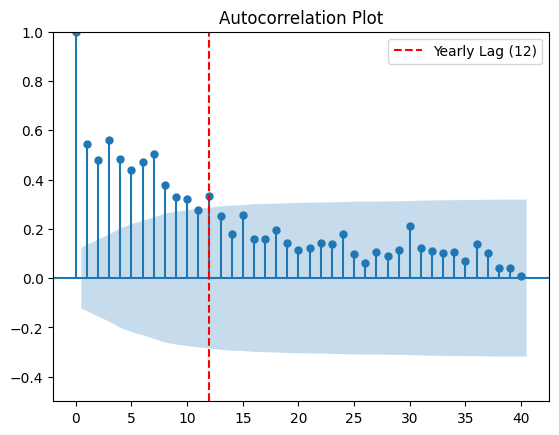

In [53]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

# Monthly data -> seasonality to check = 12 months
seasonal_lag = 12

# Ljung-Box Test
# Null hypothesis: No autocorrelation at the specified lags
ljung_box_results = acorr_ljungbox(df['y'], lags=[seasonal_lag], return_df=True)

print("Ljung-Box Test Results:")
print(ljung_box_results)

# Plot ACF
plt.figure(figsize=(10, 6))
plot_acf(df['y'], lags=40, title="Autocorrelation Plot")
plt.axvline(x=seasonal_lag, color='red', linestyle='--', label=f"Yearly Lag ({seasonal_lag})")
plt.ylim([-0.5, 1])
plt.legend()
plt.show()


Ljung-Box Test Results:
      lb_stat     lb_pvalue
12  83.508377  8.802059e-13


<Figure size 1000x600 with 0 Axes>

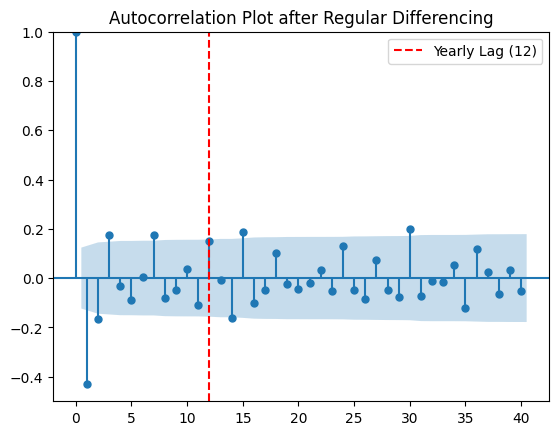

In [52]:
seasonal_lag = 12

# Ljung-Box Test
# Null hypothesis: No autocorrelation at the specified lags
ljung_box_results = acorr_ljungbox(diff, lags=[seasonal_lag], return_df=True)

# Print Ljung-Box test results
print("Ljung-Box Test Results:")
print(ljung_box_results)

# Plot Autocorrelation Function (ACF)
plt.figure(figsize=(10, 6))
plot_acf(diff1, lags=40, title="Autocorrelation Plot after Regular Differencing")
plt.axvline(x=seasonal_lag, color='red', linestyle='--', label=f"Yearly Lag ({seasonal_lag})")
plt.ylim([-0.5, 1])
plt.legend()
plt.show()


<Figure size 1000x600 with 0 Axes>

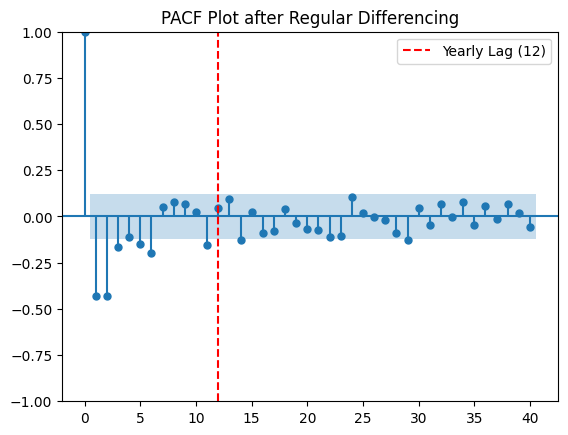

In [51]:
plt.figure(figsize=(10, 6))
diff1 = df['y_diff']
plot_pacf(diff1, lags=40, title="PACF Plot after Regular Differencing")
plt.axvline(x=seasonal_lag, color='red', linestyle='--', label=f"Yearly Lag ({seasonal_lag})")
# plt.ylim([-0.25, 1])
plt.legend()
plt.show()

In [134]:
df

,ds,y,y_diff,month
0,2003-01-01,3.116479e+09,NaN,1
1,2003-02-01,3.655906e+09,5.394272e+08,2
2,2003-03-01,2.921552e+09,-7.343544e+08,3
3,2003-04-01,2.813786e+09,-1.077658e+08,4
4,2003-05-01,3.273580e+09,4.597938e+08,5
...,...,...,...,...
247,2023-08-01,9.005704e+09,2.384549e+09,8
248,2023-09-01,6.916530e+09,-2.089174e+09,9
249,2023-10-01,8.863907e+09,1.947377e+09,10
250,2023-11-01,7.516769e+09,-1.347137e+09,11


In [153]:
from scipy.stats import kruskal

df['month'] = df['ds'].dt.month
grouped_data = [df[df['month'] == m]['y_diff'].dropna().values for m in range(1, 13)]  # Group by month

# Kruskal-Wallis test
stat, p_value = kruskal(*grouped_data)
print(f"Kruskal-Wallis Test Statistic: {stat}, p-value: {p_value}")


Kruskal-Wallis Test Statistic: 72.51937781752804, p-value: 4.0449027323467964e-11


# Training & Evaluation

## Non Regressor
- Not the final version in our report. Please refer to the regressor version below.

In [ ]:
from sklearn.metrics import mean_squared_error
from itertools import product
from tqdm import tqdm

changepoint_prior_scale_values = [0.1, 0.2, 0.5]
seasonality_prior_scale_values = [0.1, 0.5, 1.0, 10.0]
# seasonality_mode_values = ['additive', 'multiplicative']
changepoint_range_values = [0.8, 0.85, 0.9, 0.95, 1]

param_grid = list(product(changepoint_prior_scale_values,
                          seasonality_prior_scale_values,
                          changepoint_range_values))

results = []

start_date = pd.to_datetime('2016-01-01')
rolling_dates = df[df['ds'] >= start_date]['ds'].unique()

for cps, sps, cr in tqdm(param_grid, desc='hyper-paras'):
    y_pred = []
    y_actual = []

    for date in rolling_dates:
        train_end_date = date - pd.DateOffset(months=1)
        train_data = df[df['ds'] <= train_end_date]

        model = Prophet(
                changepoint_prior_scale=cps,
                seasonality_prior_scale=sps,
                changepoint_range=cr
            )
        
        try:
            model.fit(train_data, )
        except Exception as e:
            print(f"Fitting failed. cps={cps}, sps={sps}, mode={cr}, error: {e}")
            y_pred.append(None)
            y_actual.append(df[df['ds'] == date]['y'].values[0])
            continue
        
        future = model.make_future_dataframe(periods=1, freq='MS')
        forecast = model.predict(future)

        pred = forecast[forecast['ds'] == date]['yhat'].values[0]
        y_pred.append(pred)

        actual = df[df['ds'] == date]['y'].values[0]
        y_actual.append(actual)
    
    if len(y_pred) == 0:
        mse = float('inf')
    else:
        valid_indices = [i for i, pred in enumerate(y_pred) if pred is not None]
        if not valid_indices:
            mse = float('inf')
        else:
            mse = mean_squared_error(
                [y_actual[i] for i in valid_indices],
                [y_pred[i] for i in valid_indices]
            )

    results.append({
        'changepoint_prior_scale': cps,
        'seasonality_prior_scale': sps,
        'changepoint_range': cr,
        'mse': mse
    })

results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['mse'].idxmin()]
print(best_params)
print(results_df['mse'].min())

### Optimal Hyperparameters from the grid search above
- changepoint_prior_scale=0.5,
- seasonality_prior_scale=1.0,
- changepoint_range=1,
- seasonality_mode_values='additive'

In [8]:
def calculate_global_metrics(y_true, y_pred):
    """
    compute metrics
    """
    # Avoid division by zero for MAPE and SMAPE
    non_zero = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100
    smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
    
    # RMSLE
    rmsle = np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred))**2))
    
    # MSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    return {"MAPE": mape, "SMAPE": smape, "RMSLE": rmsle, "RMSE": rmse}

18:21:11 - cmdstanpy - INFO - Chain [1] start processing
18:21:11 - cmdstanpy - INFO - Chain [1] done processing
18:21:11 - cmdstanpy - INFO - Chain [1] start processing
18:21:11 - cmdstanpy - INFO - Chain [1] done processing
18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing
18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing
18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing
18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing
18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing
18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing
18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1]

{'MAPE': np.float64(29.61322520324935), 'SMAPE': np.float64(25.122139149875128), 'RMSLE': np.float64(0.34782299319716575), 'RMSE': np.float64(3842312665.923666)}


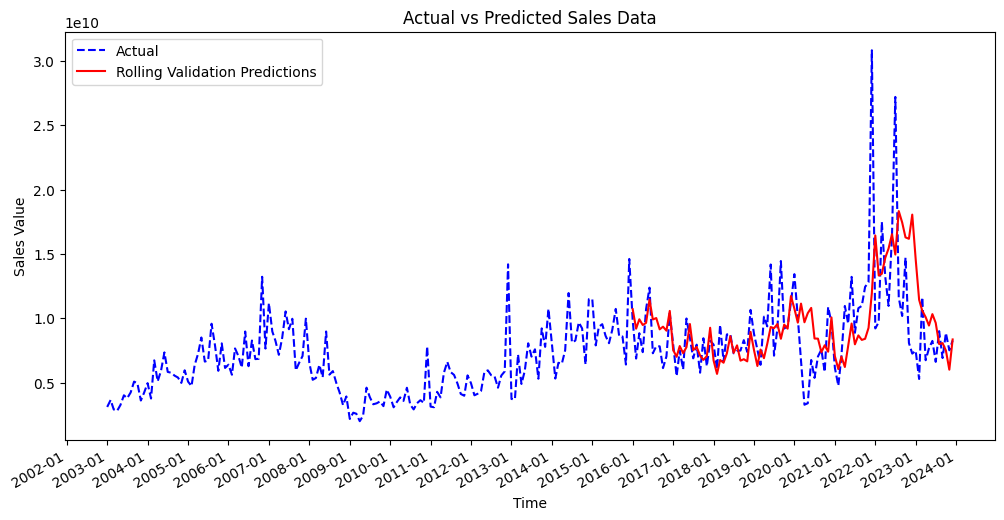

In [159]:
data['month'] = pd.to_datetime(data['month'])

# Rename columns to 'ds' and 'y' for Prophet
df = data.rename(columns={'month': 'ds', 'sale_price': 'y'})

y_pred = []
y_actual = []
dates_pred = []

# Rolling validation
start_date = pd.to_datetime('2016-01-01')
rolling_dates = df[df['ds'] >= start_date]['ds'].unique()

for date in rolling_dates:
    # Define training data up to date - 1 month
    train_end_date = date - pd.DateOffset(months=1)
    train_data = df[df['ds'] <= train_end_date]
    
    model = Prophet(
                changepoint_prior_scale=0.5,
                seasonality_prior_scale=1.0,
                changepoint_range=1
            )
    model.fit(train_data)
    
    # Make predictions
    future = model.make_future_dataframe(periods=1, freq='MS')
    forecast = model.predict(future)
    
    pred = forecast[forecast['ds'] == date]['yhat'].values[0]
    y_pred.append(pred)
    dates_pred.append(date)
    
    # Get the actual value
    actual = df[df['ds'] == date]['y'].values[0]
    y_actual.append(actual)

y_pred = np.array(y_pred)
y_actual = np.array(y_actual)
print(calculate_global_metrics(y_actual, y_pred))

# Plot
months = df['ds']
y_original = df['y']

plt.figure(figsize=(12, 6))
plt.plot(months, y_original, label='Actual', color='blue', linestyle='--')
plt.plot(dates_pred, y_pred, label='Rolling Validation Predictions', color='red')
plt.title('Actual vs Predicted Sales Data')
plt.xlabel('Time')
plt.ylabel('Sales Value')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

## [Final Report Vers.] Regressor - Focusing on recent data
### Grid Search for Prophet with regressor

In [ ]:
from sklearn.metrics import mean_squared_error
from itertools import product
from tqdm import tqdm

changepoint_prior_scale_values = [0.1, 0.2, 0.5]
seasonality_prior_scale_values = [0.1, 0.5, 1.0, 10.0]
# seasonality_mode_values = ['additive', 'multiplicative']
changepoint_range_values = [0.8, 0.85, 0.9, 0.95, 1]

param_grid = list(product(changepoint_prior_scale_values,
                          seasonality_prior_scale_values,
                          changepoint_range_values))

results = []

start_date = pd.to_datetime('2016-01-01')
rolling_dates = df[df['ds'] >= start_date]['ds'].unique()

for cps, sps, cr in tqdm(param_grid, desc='hyper-paras'):
    y_pred = []
    y_actual = []

    for date in rolling_dates:
        train_end_date = date - pd.DateOffset(months=1)
        train_data = df[df['ds'] <= train_end_date].copy()
        cutoff_date = train_end_date - pd.DateOffset(months=12)
        train_data['recent'] = (train_data['ds'] >= cutoff_date).astype(int)

        model = Prophet(
                changepoint_prior_scale=cps,
                seasonality_prior_scale=sps,
                changepoint_range=cr
            )
        
        model.add_regressor('recent')
        
        try:
            model.fit(train_data, )
        except Exception as e:
            print(f"Fitting failed. cps={cps}, sps={sps}, mode={cr}, error: {e}")
            y_pred.append(None)
            y_actual.append(df[df['ds'] == date]['y'].values[0])
            continue
        
        future = model.make_future_dataframe(periods=1, freq='MS')
        future['recent'] = 1
        forecast = model.predict(future)

        pred = forecast[forecast['ds'] == date]['yhat'].values[0]
        y_pred.append(pred)

        actual = df[df['ds'] == date]['y'].values[0]
        y_actual.append(actual)
    
    if len(y_pred) == 0:
        mse = float('inf')
    else:
        valid_indices = [i for i, pred in enumerate(y_pred) if pred is not None]
        if not valid_indices:
            mse = float('inf')
        else:
            mse = mean_squared_error(
                [y_actual[i] for i in valid_indices],
                [y_pred[i] for i in valid_indices]
            )

    results.append({
        'changepoint_prior_scale': cps,
        'seasonality_prior_scale': sps,
        'changepoint_range': cr,
        'mse': mse
    })

results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['mse'].idxmin()]
print(best_params)
print(results_df['mse'].min())

### Optimal Hyperparameters from the grid search above
- changepoint_prior_scale=0.5,
- seasonality_prior_scale=0.5,
- changepoint_range=0.95,
- seasonality_mode_values='additive'

21:04:32 - cmdstanpy - INFO - Chain [1] start processing
21:04:32 - cmdstanpy - INFO - Chain [1] done processing
21:04:32 - cmdstanpy - INFO - Chain [1] start processing
21:04:32 - cmdstanpy - INFO - Chain [1] done processing
21:04:32 - cmdstanpy - INFO - Chain [1] start processing
21:04:32 - cmdstanpy - INFO - Chain [1] done processing
21:04:32 - cmdstanpy - INFO - Chain [1] start processing
21:04:32 - cmdstanpy - INFO - Chain [1] done processing
21:04:32 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1]

{'MAPE': np.float64(29.83718463959047), 'SMAPE': np.float64(25.86707898042467), 'RMSLE': np.float64(0.3443789484379221), 'RMSE': np.float64(3799762511.220434)}


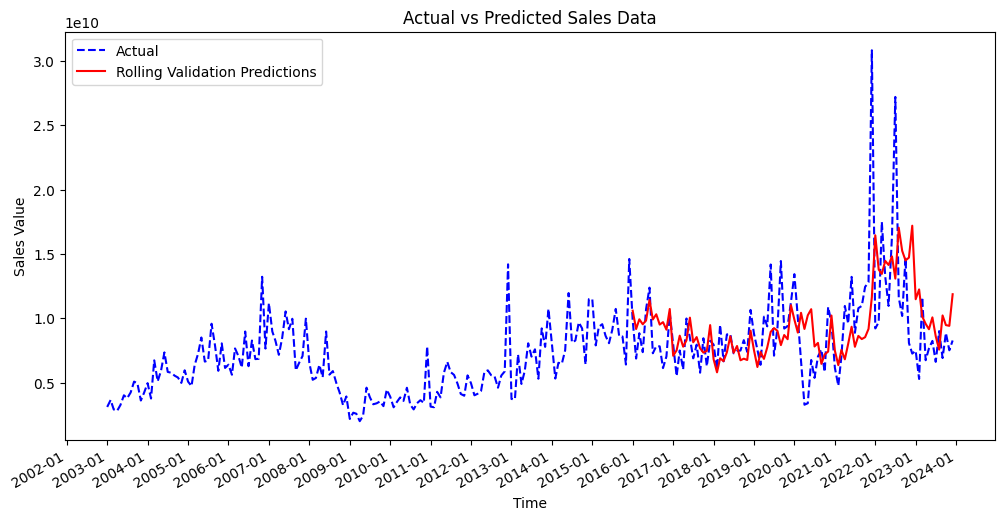

In [197]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data['month'] = pd.to_datetime(data['month'])
df = data.rename(columns={'month': 'ds', 'sale_price': 'y'})

y_pred = []
y_actual = []
dates_pred = []

start_date = pd.to_datetime('2016-01-01')
rolling_dates = df[df['ds'] >= start_date]['ds'].unique()

for date in rolling_dates:
    train_end_date = date - pd.DateOffset(months=1)
    train_data = df[df['ds'] <= train_end_date].copy()
    cutoff_date = train_end_date - pd.DateOffset(months=12)
    train_data['recent'] = (train_data['ds'] >= cutoff_date).astype(int)
    
    model = Prophet(
        changepoint_prior_scale=0.5,
        seasonality_prior_scale=0.5,
        changepoint_range=0.95
    )
    model.add_regressor('recent')
    model.fit(train_data)
    
    future = model.make_future_dataframe(periods=1, freq='MS')
    future['recent'] = 1
    forecast = model.predict(future)
    
    pred = forecast[forecast['ds'] == date]['yhat'].values[0]
    y_pred.append(pred)
    dates_pred.append(date)
    
    actual = df[df['ds'] == date]['y'].values[0]
    y_actual.append(actual)

y_pred = np.array(y_pred)
y_actual = np.array(y_actual)
print(calculate_global_metrics(y_actual, y_pred))

months = df['ds']
y_original = df['y']

plt.figure(figsize=(12, 6))
plt.plot(months, y_original, label='Actual', color='blue', linestyle='--')
plt.plot(dates_pred, y_pred, label='Rolling Validation Predictions', color='red')
plt.title('Actual vs Predicted Sales Data')
plt.xlabel('Time')
plt.ylabel('Sales Value')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()


### Visualize the Prophet Components for Interpretability

/var/folders/7k/wt0q78rj0zg70hm4j8_x9lgh0000gn/T/ipykernel_57171/2518197385.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


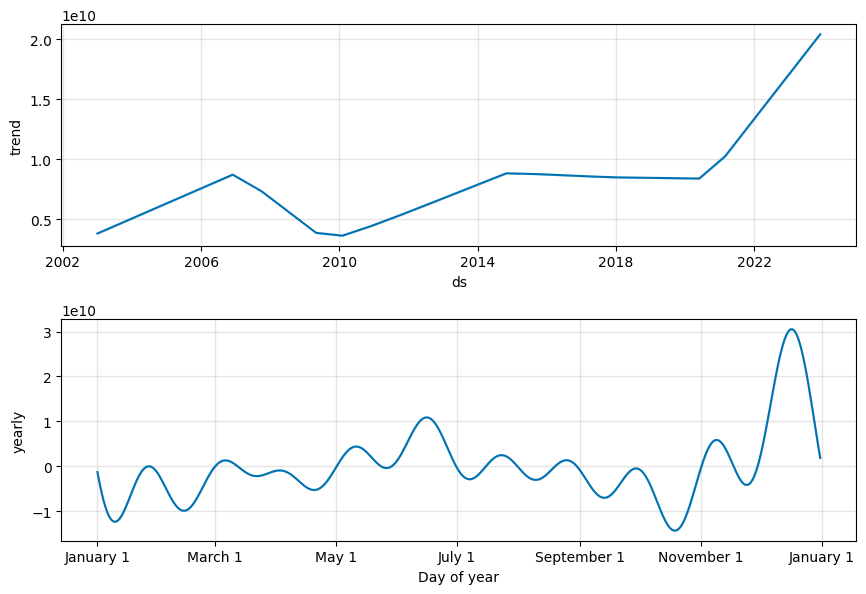

In [198]:
fig = model.plot_components(forecast)
axes = fig.get_axes()
for i, ax in enumerate(axes):
    if i not in [0, 1]:
        ax.set_visible(False)

fig.show()

In [ ]:
# compare seasonality and the true data

df['ds'] = pd.to_datetime(df['ds'])

df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
monthly_trends = df.pivot(index='year', columns='month', values='y')


fig, ax1 = plt.subplots(figsize=(12, 6))

years = monthly_trends.index
num_years = len(years)
colors = cm.Greens(np.linspace(0.4, 0.8, num_years))

for i, year in enumerate(years):
    ax1.plot(
        monthly_trends.columns, 
        monthly_trends.loc[year], 
        color=colors[i], 
        label=str(year) if i % 10 == 0 else ""
    )

ax1.set_xlabel('Month')
ax1.set_ylabel('Original Data Value')
ax1.grid(alpha=0.3)
ax1.legend(title='Year', loc='upper left', fontsize='small')
ax1.set_title('Monthly Patterns Across Years with Yearly Seasonality')


ax2 = ax1.twinx()
yearly = forecast[['ds', 'yearly']]
yearly['month'] = yearly['ds'].dt.month
monthly_yearly = yearly.groupby('month')['yearly'].mean()

ax2.plot(
    monthly_yearly.index, 
    monthly_yearly.values, 
    color='red', 
    label='Prophet Yearly Seasonality',
    linestyle='--'
)

ax2.set_ylabel('Yearly Seasonality Value (Prophet)')
ax2.legend(loc='upper right')

plt.show()
# for the output fig, refer to our report

# Seperate Housing types
## A&B

In [162]:
df = ab

df['sale_date'] = pd.to_datetime(df['sale_date'])
df['month'] = df['sale_date'].dt.to_period('M')
df['week'] = df['sale_date'].dt.to_period('W')

monthly_avg = df.groupby('month')['sale_price'].sum().reset_index()
monthly_avg['month'] = monthly_avg['month'].dt.to_timestamp()

data = monthly_avg

# Ensure 'month' column is datetime
data['month'] = pd.to_datetime(data['month'])

# Rename columns to 'ds' and 'y' for Prophet
df = data.rename(columns={'month': 'ds', 'sale_price': 'y'})

In [ ]:
from sklearn.metrics import mean_squared_error
from itertools import product
from tqdm import tqdm

changepoint_prior_scale_values = [0.1, 0.2, 0.5]
seasonality_prior_scale_values = [0.1, 0.5, 1.0, 10.0]
# seasonality_mode_values = ['additive', 'multiplicative']
changepoint_range_values = [0.8, 0.85, 0.9, 0.95, 1]

param_grid = list(product(changepoint_prior_scale_values,
                          seasonality_prior_scale_values,
                          changepoint_range_values))

results = []

start_date = pd.to_datetime('2016-01-01')
rolling_dates = df[df['ds'] >= start_date]['ds'].unique()

for cps, sps, cr in tqdm(param_grid, desc='hyper-paras'):
    y_pred = []
    y_actual = []

    for date in rolling_dates:
        train_end_date = date - pd.DateOffset(months=1)
        train_data = df[df['ds'] <= train_end_date].copy()
        cutoff_date = train_end_date - pd.DateOffset(months=12)
        train_data['recent'] = (train_data['ds'] >= cutoff_date).astype(int)

        model = Prophet(
                changepoint_prior_scale=cps,
                seasonality_prior_scale=sps,
                changepoint_range=cr
            )
        
        model.add_regressor('recent')
        
        try:
            model.fit(train_data, )
        except Exception as e:
            print(f"Fitting failed. cps={cps}, sps={sps}, mode={cr}, error: {e}")
            y_pred.append(None)
            y_actual.append(df[df['ds'] == date]['y'].values[0])
            continue
        
        future = model.make_future_dataframe(periods=1, freq='MS')
        future['recent'] = 1
        forecast = model.predict(future)

        pred = forecast[forecast['ds'] == date]['yhat'].values[0]
        y_pred.append(pred)

        actual = df[df['ds'] == date]['y'].values[0]
        y_actual.append(actual)
    
    if len(y_pred) == 0:
        mse = float('inf')
    else:
        valid_indices = [i for i, pred in enumerate(y_pred) if pred is not None]
        if not valid_indices:
            mse = float('inf')
        else:
            mse = mean_squared_error(
                [y_actual[i] for i in valid_indices],
                [y_pred[i] for i in valid_indices]
            )

    results.append({
        'changepoint_prior_scale': cps,
        'seasonality_prior_scale': sps,
        'changepoint_range': cr,
        'mse': mse
    })

results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['mse'].idxmin()]
print(best_params)
print(results_df['mse'].min())

### Optimal Hyperparameters from the grid search above
- changepoint_prior_scale=0.5,
- seasonality_prior_scale=0.1,
- changepoint_range=1.0,
- seasonality_mode_values='additive'

20:28:06 - cmdstanpy - INFO - Chain [1] start processing
20:28:06 - cmdstanpy - INFO - Chain [1] done processing
20:28:07 - cmdstanpy - INFO - Chain [1] start processing
20:28:07 - cmdstanpy - INFO - Chain [1] done processing
20:28:07 - cmdstanpy - INFO - Chain [1] start processing
20:28:07 - cmdstanpy - INFO - Chain [1] done processing
20:28:07 - cmdstanpy - INFO - Chain [1] start processing
20:28:07 - cmdstanpy - INFO - Chain [1] done processing
20:28:07 - cmdstanpy - INFO - Chain [1] start processing
20:28:07 - cmdstanpy - INFO - Chain [1] done processing
20:28:07 - cmdstanpy - INFO - Chain [1] start processing
20:28:07 - cmdstanpy - INFO - Chain [1] done processing
20:28:07 - cmdstanpy - INFO - Chain [1] start processing
20:28:07 - cmdstanpy - INFO - Chain [1] done processing
20:28:07 - cmdstanpy - INFO - Chain [1] start processing
20:28:07 - cmdstanpy - INFO - Chain [1] done processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1]

{'MAPE': np.float64(13.453840943180392), 'SMAPE': np.float64(13.062402340733126), 'RMSLE': np.float64(0.1897375733910273), 'RMSE': np.float64(258570323.0218212)}


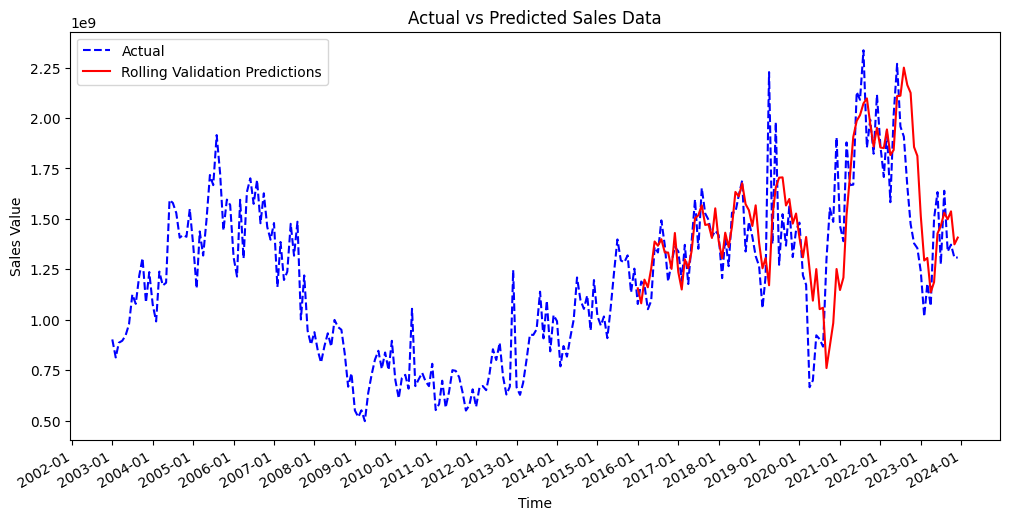

In [165]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data['month'] = pd.to_datetime(data['month'])
df = data.rename(columns={'month': 'ds', 'sale_price': 'y'})

y_pred = []
y_actual = []
dates_pred = []

start_date = pd.to_datetime('2016-01-01')
rolling_dates = df[df['ds'] >= start_date]['ds'].unique()

for date in rolling_dates:
    train_end_date = date - pd.DateOffset(months=1)
    train_data = df[df['ds'] <= train_end_date].copy()
    cutoff_date = train_end_date - pd.DateOffset(months=12)
    train_data['recent'] = (train_data['ds'] >= cutoff_date).astype(int)
    
    model = Prophet(
        changepoint_prior_scale=0.5,
        seasonality_prior_scale=0.1,
        changepoint_range=1
    )
    model.add_regressor('recent')
    model.fit(train_data)
    
    future = model.make_future_dataframe(periods=1, freq='MS')
    future['recent'] = 1
    forecast = model.predict(future)
    
    pred = forecast[forecast['ds'] == date]['yhat'].values[0]
    y_pred.append(pred)
    dates_pred.append(date)
    
    actual = df[df['ds'] == date]['y'].values[0]
    y_actual.append(actual)

y_pred = np.array(y_pred)
y_actual = np.array(y_actual)
print(calculate_global_metrics(y_actual, y_pred))

months = df['ds']
y_original = df['y']

plt.figure(figsize=(12, 6))
plt.plot(months, y_original, label='Actual', color='blue', linestyle='--')
plt.plot(dates_pred, y_pred, label='Rolling Validation Predictions', color='red')
plt.title('Actual vs Predicted Sales Data')
plt.xlabel('Time')
plt.ylabel('Sales Value')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()


## C&D

In [166]:
df = cd

df['sale_date'] = pd.to_datetime(df['sale_date'])
df['month'] = df['sale_date'].dt.to_period('M')
df['week'] = df['sale_date'].dt.to_period('W')

monthly_avg = df.groupby('month')['sale_price'].sum().reset_index()
monthly_avg['month'] = monthly_avg['month'].dt.to_timestamp()

data = monthly_avg

# Ensure 'month' column is datetime
data['month'] = pd.to_datetime(data['month'])

# Rename columns to 'ds' and 'y' for Prophet
df = data.rename(columns={'month': 'ds', 'sale_price': 'y'})

In [ ]:
from sklearn.metrics import mean_squared_error
from itertools import product
from tqdm import tqdm

changepoint_prior_scale_values = [0.1, 0.2, 0.5]
seasonality_prior_scale_values = [0.1, 0.5, 1.0, 10.0]
# seasonality_mode_values = ['additive', 'multiplicative']
changepoint_range_values = [0.8, 0.85, 0.9, 0.95, 1]

param_grid = list(product(changepoint_prior_scale_values,
                          seasonality_prior_scale_values,
                          changepoint_range_values))

results = []

start_date = pd.to_datetime('2016-01-01')
rolling_dates = df[df['ds'] >= start_date]['ds'].unique()

for cps, sps, cr in tqdm(param_grid, desc='hyper-paras'):
    y_pred = []
    y_actual = []

    for date in rolling_dates:
        train_end_date = date - pd.DateOffset(months=1)
        train_data = df[df['ds'] <= train_end_date].copy()
        cutoff_date = train_end_date - pd.DateOffset(months=12)
        train_data['recent'] = (train_data['ds'] >= cutoff_date).astype(int)

        model = Prophet(
                changepoint_prior_scale=cps,
                seasonality_prior_scale=sps,
                changepoint_range=cr
            )
        
        model.add_regressor('recent')
        
        try:
            model.fit(train_data, )
        except Exception as e:
            print(f"Fitting failed. cps={cps}, sps={sps}, mode={cr}, error: {e}")
            y_pred.append(None)
            y_actual.append(df[df['ds'] == date]['y'].values[0])
            continue
        
        future = model.make_future_dataframe(periods=1, freq='MS')
        future['recent'] = 1
        forecast = model.predict(future)

        pred = forecast[forecast['ds'] == date]['yhat'].values[0]
        y_pred.append(pred)

        actual = df[df['ds'] == date]['y'].values[0]
        y_actual.append(actual)
    
    if len(y_pred) == 0:
        mse = float('inf')
    else:
        valid_indices = [i for i, pred in enumerate(y_pred) if pred is not None]
        if not valid_indices:
            mse = float('inf')
        else:
            mse = mean_squared_error(
                [y_actual[i] for i in valid_indices],
                [y_pred[i] for i in valid_indices]
            )

    results.append({
        'changepoint_prior_scale': cps,
        'seasonality_prior_scale': sps,
        'changepoint_range': cr,
        'mse': mse
    })

results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['mse'].idxmin()]
print(best_params)
print(results_df['mse'].min())

### Optimal Hyperparameters from the grid search above
- changepoint_prior_scale=0.1,
- seasonality_prior_scale=0.1,
- changepoint_range=0.95,
- seasonality_mode_values='additive'